In [ ]:
# import libraries
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses

import os
import numpy as np
import pandas as pd
!pip install pickle5
import pickle5 as pickle
from skimage.transform import resize as sk_resize

     |████████████████████████████████| 256 kB 4.3 MB/s 


In [ ]:
# connect Drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# load data
path = '/content/drive/MyDrive/W210/Wafer-Defect-Classification'

with open(f'{path}/WM-clean.pkl', "rb") as fh:
    raw_data = pickle.load(fh)
    
print(f'Raw data shape: {raw_data.shape}')

Raw data shape: (172950, 11)


In [ ]:
# add classification model labels
fail_types = raw_data.failureType.unique()
fail_dict = {fail_types[i]:i for i in range(len(fail_types))}
print(fail_dict)

raw_data['classify_labels'] = raw_data['failureType'].apply(lambda x: fail_dict[x])
raw_data.head()

{'none': 0, 'Loc': 1, 'Edge-Loc': 2, 'Center': 3, 'Edge-Ring': 4, 'Scratch': 5, 'Random': 6, 'Near-full': 7, 'Donut': 8}


,waferMap,dieSize,lotName,waferIndex,failureType,encoding,x_,y_,shape,labels,dataset,classify_labels
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train,0
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",test,0
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",test,0
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train,0
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train,0


In [ ]:
# remove failture type of none
filtered_data = raw_data[raw_data.failureType != 'none']
print(f'Filtered data shape: {filtered_data.shape}')

Filtered data shape: (25519, 12)


In [ ]:
# resize images to 32x32
# normalize values to range of [0,1]
filtered_data['resized_map'] = filtered_data.waferMap.apply(lambda x: sk_resize(x/2, [32, 32], order=0, preserve_range=True, anti_aliasing=False))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# split data into train, dev, and test sets
train = filtered_data[filtered_data.dataset == 'train'].reset_index(drop=True)
dev = filtered_data[filtered_data.dataset == 'dev'].reset_index(drop=True)
test = filtered_data[filtered_data.dataset == 'test'].reset_index(drop=True)
print(f"Train: {len(train)}")
print(f"Dev: {len(dev)}")
print(f"Test: {len(test)}")

Train: 17863
Dev: 3828
Test: 3828


In [ ]:
x_train = np.stack(train['resized_map'])
x_val = np.stack(dev['resized_map'])
x_test = np.stack(test['resized_map'])
x_train.shape

(17863, 32, 32)

In [ ]:
# expand tensor and create dummy dimension at axis 3
# images in greyscale, so no channel dimension
x_train = tf.expand_dims(x_train, axis=3, name=None)
x_val = tf.expand_dims(x_val, axis=3, name=None)
x_test = tf.expand_dims(x_test, axis=3, name=None)
x_train.shape

TensorShape([17863, 32, 32, 1])

In [ ]:
y_train = np.asarray(train['classify_labels'])
y_val = np.asarray(dev['classify_labels'])
y_test = np.asarray(test['classify_labels'])

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(6, 5, activation='tanh', input_shape=x_train.shape[1:]))
model.add(layers.AveragePooling2D(2))
model.add(layers.Activation('sigmoid'))
model.add(layers.Conv2D(16, 5, activation='tanh'))
model.add(layers.AveragePooling2D(2))
model.add(layers.Activation('sigmoid'))
model.add(layers.Conv2D(120, 5, activation='tanh'))
model.add(layers.Flatten())
model.add(layers.Dense(84, activation='tanh'))
model.add(layers.Dense(10, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 6)        0         
 ooling2D)                                                       
                                                                 
 activation (Activation)     (None, 14, 14, 6)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_1 (Averag  (None, 5, 5, 16)         0         
 ePooling2D)                                                     
                                                                 
 activation_1 (Activation)   (None, 5, 5, 16)          0

In [ ]:
model.compile(optimizer='adam', loss=losses.sparse_categorical_crossentropy, metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, y_train, batch_size=64, epochs=40, validation_data=(x_val, y_val))

Epoch 1/40
280/280 [==============================] - 12s 8ms/step - loss: 1.6621 - accuracy: 0.3741 - val_loss: 1.6559 - val_accuracy: 0.3793
Epoch 2/40
280/280 [==============================] - 2s 6ms/step - loss: 1.6465 - accuracy: 0.3793 - val_loss: 1.6418 - val_accuracy: 0.3793
Epoch 3/40
280/280 [==============================] - 2s 7ms/step - loss: 1.6066 - accuracy: 0.3957 - val_loss: 1.3923 - val_accuracy: 0.4775
Epoch 4/40
280/280 [==============================] - 2s 7ms/step - loss: 1.2758 - accuracy: 0.5220 - val_loss: 1.2144 - val_accuracy: 0.5400
Epoch 5/40
280/280 [==============================] - 2s 7ms/step - loss: 1.1301 - accuracy: 0.5730 - val_loss: 1.4341 - val_accuracy: 0.4475
Epoch 6/40
280/280 [==============================] - 2s 7ms/step - loss: 1.0886 - accuracy: 0.5854 - val_loss: 1.0525 - val_accuracy: 0.6055
Epoch 7/40
280/280 [==============================] - 2s 7ms/step - loss: 1.0450 - accuracy: 0.5953 - val_loss: 1.0433 - val_accuracy: 0.6136
Epoch

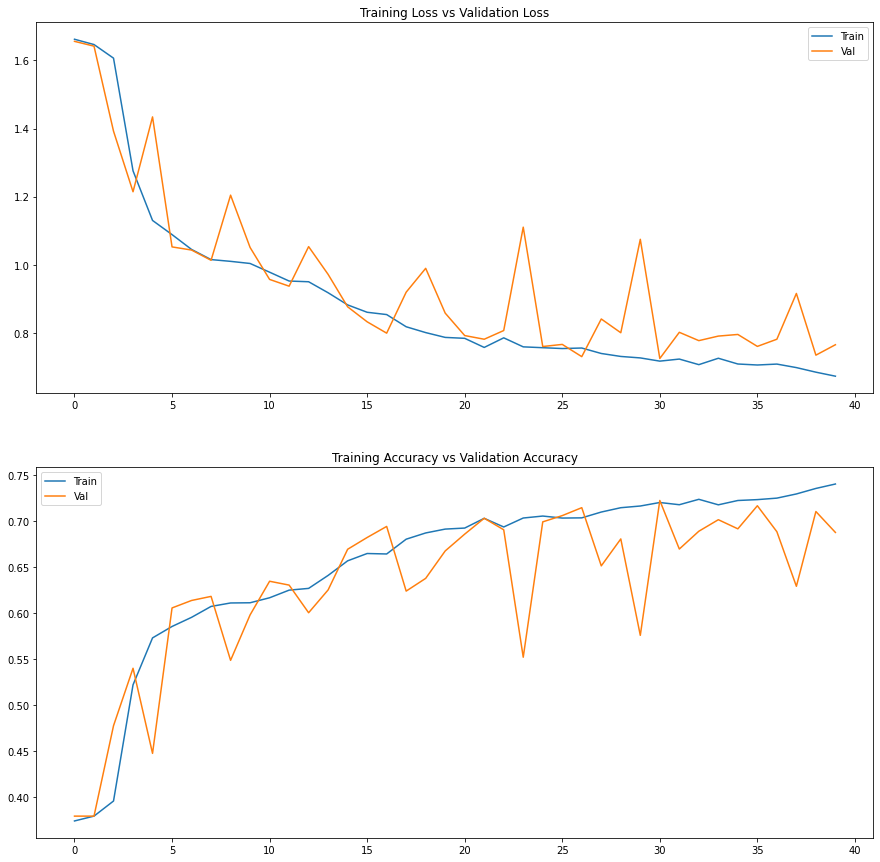

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].legend(['Train', 'Val'])

axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].legend(['Train', 'Val'])


In [ ]:
model.evaluate(x_test, y_test)

120/120 [==============================] - 1s 4ms/step - loss: 0.7532 - accuracy: 0.6834


[0.753183901309967, 0.6833855509757996]